# Breast Cancer Multi-Class Classification with Keras

### 1. Importing libraries and modules

The libraries and modules used throughout the project are:

In [1]:
# Import libraries and modules
import matplotlib.pyplot as plt                                  # Data visualization
import numpy as np                                               # Data manipulation using arrays
import pandas as pd                                              # Data manipulation and analysis 
import tensorflow as tf                                          # Machine learning platform

from tensorflow import keras                                     # Interface for Artificial Neural Network
from tensorflow.keras import layers                              # Neural Network layers
from tensorflow.keras.callbacks import EarlyStopping             # Regularization method for overfitting
from sklearn.decomposition import PCA                            # Dimensionality reduction 
from sklearn.model_selection import StratifiedKFold              # Cross-validation 
from sklearn.preprocessing import StandardScaler, LabelEncoder   # Data preprocessing

# Enable inline plotting
%matplotlib inline                                               

The global random seed has been set for TensorFlow to ensure reproducible outputs across multiple calls:

In [ ]:
# Set tensorflow random seed for reproducible results
tf.random.set_seed(42)

### 2. Data loading and preprocessing

#### 2.1. Loading

The data set with ID 'GSE26304' as downloaded from the CuMiDa website in a Comma Separated Values (CSV) format is initially loaded and inspected in a pandas data frame:

In [8]:
df = pd.read_csv('./Breast_GSE26304.csv')           # Load a CSV file in pandas DataFrame 
df.shape                                            # Shape of the dataframe (115, 33639) 

(115, 33639)

In [9]:
df.columns                                          # Columns: sample idx, type of cancer, 33638 x genes

Index(['samples', 'type', 'NM_001003689', 'NM_005503', 'NM_004672',
       'NM_001008727', 'Pro25G', 'NM_020630', 'BX094364', 'ENST00000333722',
       ...
       'NM_178354', 'BC030115', 'NM_019005', 'NM_001974', 'A_32_P206917',
       'THC2406077', 'NR_001446', 'THC2336333', 'BC033812', 'THC2345075'],
      dtype='object', length=33639)

In [11]:
df['type'].unique()                                 # Explore breast cancer types

array(['breast_cancer_mixed', 'breast_cancer_dcis', 'breast_cancer_idc',
       'normal'], dtype=object)

The data set consists of 115 samples and 33 639 columns in total (start count at zero). The
first two columns are the sample index and the type of cancer, whereas the remaining 33 638
features correspond to gene expression data. <br>
Column 'type' consists of four unique categories for classification with the following sample distribution:<br> 
1. breast cancer mixed (42),<br> 
2. breast cancer dcis (31),<br> 
3. breast cancer idc (36), and <br> 
4. normal (6).

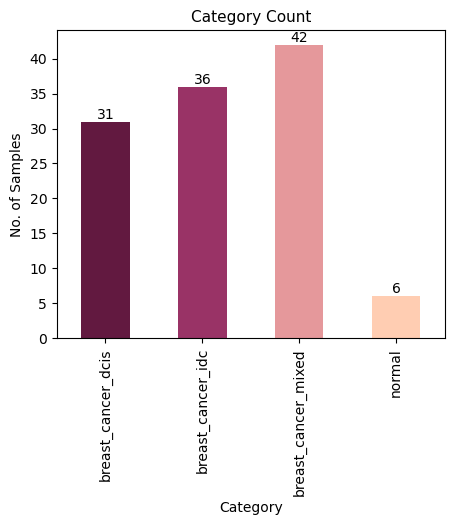

In [46]:
types = df.groupby(['type']).size()                          # Group by cancer type  
colors=['#621940', '#993366','#E5989B', '#FFCDB2']           # Define color palette
ax = types.plot(kind='bar', color=colors, figsize=(5, 4))    # Plot count for cancer type

ax.bar_label(ax.containers[0])                      # Display bar count
ax.set_xlabel('Category', fontsize=10)              # Set label for the X-axis
ax.set_ylabel('No. of Samples', fontsize=10)        # Set label for the Y-axis
ax.set_title('Category Count', fontsize=11)         # Set figure title            
plt.show()                                          # Show figure

#### 2.2. Preprocessing 

In the next step, the data is split into: <br>
 - **y** : features, by dropping the first two columns (i.e., ’sample’ and ’type’ ) and preserving the gene expression data, and <br>
 -  **X** : corresponding labels, by assigning column ’type’ which contains the breast cancer category for each sample. 

In [13]:
# Get the features and corresponding labels (X, y) 
X = df.drop(['samples', 'type'], axis=1)
y = df['type']

**Standardization.** Since the data set contains a large number of features (over 33 000), it is often a good practice perform *Principal Component Analysis (PCA)* – reducing the set of features into a smaller number of variables called principal components while retaining as much information from the original data set as possible. However, PCA is a variance maximazing exercise which requires features to be scaled prior to processing. To check whether the original data set is standardized, the mean and standard deviation have been calculated per feature (column):

In [14]:
# Check if the data is already normalized/standardized
X.mean(axis=0)                              # Mean of each column

NM_001003689    0.503836
NM_005503       0.477631
NM_004672       0.437132
NM_001008727    0.332080
Pro25G          0.600234
                  ...   
THC2406077      0.394533
NR_001446       0.335505
THC2336333      0.443152
BC033812        0.448339
THC2345075      0.454387
Length: 33637, dtype: float64

In [15]:
X.std(axis=0)                               # Standard deviation of each column

NM_001003689    0.503836
NM_005503       0.477631
NM_004672       0.437132
NM_001008727    0.332080
Pro25G          0.600234
                  ...   
THC2406077      0.394533
NR_001446       0.335505
THC2336333      0.443152
BC033812        0.448339
THC2345075      0.454387
Length: 33637, dtype: float64

It is clear from the results that the original data is not standard normally distributed Gaussian with zero mean and unit variance.
Therefore, scaling was performed using the StandardScaler() class from scikit-learn:

In [21]:
# Perform standardization
scaler  = StandardScaler()                  # Specify the standardization algorithm
X_scaled = scaler.fit_transform(X)          # Fit and transform the data 

# Check if the data is standardized after the transformation
print('Mean: {0:.2f} \nStandard deviation: {1:.2f}'.format(np.mean(X_scaled), np.std(X_scaled)))

Mean: -0.00 
Standard deviation: 1.00


**Reducing dimensionality - PCA.** After standardizing the data, PCA is applied to the scaled features (X_scaled). The initializer of the PCA class has a parameter named n_components which is assigned to None, indicating equal number of principal components with the number of features in the dataset. Once the components are determined using the fit() method, the cumulative sum of the explained variance ratio for each principal component (PC) is calculated and the results are analysed using a graphical representation of the % of variation that each principal component (PC) accounts for - a scree plot:

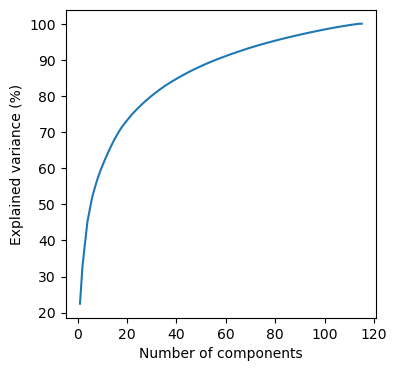

In [40]:
# Perform PCA fit on the scaled features
# No. components == no. original features in the dataset
pca = PCA(n_components = None) 
pca.fit(X_scaled)

# Calculate cumulative sum of the explained variance ratio for each PC
cumsum_variances = pca.explained_variance_ratio_.cumsum() * 100
#print('Cumulative Variances (%):', cumsum_variances)

# Total number of principal components
components = len(cumsum_variances)                                  

# Plot a scree plot 
plt.plot(range(1,components+1), cumsum_variances)  # Plot data
plt.xlabel('Number of components')                 # Set label for X axis
plt.ylabel('Explained variance (%)')               # Set label for Y axis
plt.rcParams["figure.figsize"] = (4, 3)            # Set figure size
plt.show()                                         # Show figure

Although in theory, there is one PC per gene (or feature), in practice, the number of PCs is either the number of features or the number of samples, whichever is smaller. In the present data set the number of samples (115) is significantly smaller than the number of features (33 638), thus, the total number of principal components is 115. To capture the whole variability in the data, in the steps that follow all 115 PCs are used for the decomposition of the 33 638 features (gene expressions). <br>
After PCA transformation the data consists of 115 samples each with 115 components (features):

In [47]:
# Perform PCA transform on the scaled features
X_pca = pca.transform(X_scaled)
print(X_pca.shape)    

(115, 115)


**Encoding category labels.** The last part of data preprocessing compromises label encoding to integer
values for the different cancer types. For this purpose, a LabelEncoder() is used which replaces
the categorical data with a numeric value between 0 and 3 (for a total of 4 cancer types):

In [49]:
# Encode categorical data to integer labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  

# Check mapping of categorical data and print results
le_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_map)

{'breast_cancer_dcis': 0, 'breast_cancer_idc': 1, 'breast_cancer_mixed': 2, 'normal': 3}


### 3. Building a neural network (NN) model

Next, a function build model() is defined which specifies the NN model to be used for the classification of the different cancer types based on the gene expression data: <br>

 - The NN model is build with Keras Sequential API and its architecture compromises a single hidden layer with 12 nodes and 115 units (for each feature - principal component). <p></p>  

 - The forward pass applies the rectified linear (ReLU) activation function with the current standard approach for initialization of the weights, namely, ’he normal’ initialization.<p></p>
 
 - The hidden layer is proceeded by a Dropout layer to prevent complex co-adaptations on training data by setting input units to 0 with a frequency of rate at each step during training time. The fraction of the input units to drop is set to 20 %.<p></p> 
 
 - Finally, an output layer with 4 nodes is added to the network with the softmax activation function which is the most commonly used function for multi-class classification problems. Softmax will output one value for each node in the output layer, which can be interpreted as probabilities and sum to 1.0. Such an output dictates the need for one-hot-encoding of the label encoded cancer types, resulting in a probabilistic representation of the category labels, much like the softmax output. However, this action will be undertaken latter on in the code.<p></p>
 
 - In compliance with softmax, the categorical cross-entropy is used as a loss function to determine the error between the expected and predicted multinomial probability distribution.<p></p> 
 
 - The NN model is compiled with the state-of-art Adam optimizer, which usually ensures a good convergence and reduces the need for a cumbersome determination of the optimal learning rate. During compilation, the accuracy of the model is used as a tracking metric. <br>
 
The build_model() function returns a compiled model, the hyperparameters of which are fit for this project. Lastly, this function is called by assigning it to the object model:

In [50]:
def build_model():
    # Create model with Keras sequential API
    # Add hidden layer with 12 nodes and 115 units as input 
    # Add a dropout layer (rate = 20 %) to help reduce overfitting
    # Add output layer with 4 units
    model = keras.Sequential([
        layers.Dense(12, input_dim=115, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Dense(4, activation='softmax')
        ])
    
    # Print model summary
    print(model.summary())
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                1392      
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 52        
                                                                 
Total params: 1,444
Trainable params: 1,444
Non-trainable params: 0
_________________________________________________________________
None


### 4. Evaluating the NN model

To be consistent with the results presented in the CuMiDa website for the evaluation of the performance of other ML algorithms, the validation of the NN model is done using a three-fold stratified cross-validation. In addition, the StratifiedKFold method has the advantage of preserving the percentage of samples for each category during the data split, which is especially useful when dealing with an imbalanced data set:<br>

- Initially, the EarlyStopping callback is defined with the metric to be tracked set to ’accuracy’. This callback will monitor the model’s accuracy during training and stop the training process if the accuracy does not improve for 10 consecutive epochs, in order to prevent overfitting. <p></p>

- The StratifiedKFold method is defined with three folds. A dictionary called histories is initialized with empty lists to store the results of the cross-validation.  <p></p>

- Then, a for-loop iterates over the folds generated by the StratifiedKFold method. For each fold, the data is split into training and validation sets using the indices generated by the StratifiedKFold method. The labels are converted to one-hot-encoded vectors using the Keras utility function to categorical() to comply with the sofmax output values. <p></p>

- The model is then fit to the training data for 200 epochs using the fit() method, with the EarlyStopping callback passed as an argument. The history of the training process is saved in the ’history’ variable. <p></p>

- Next, the model is evaluated on the validation data using the evaluate() method, and the accuracy and loss scores are saved in the ’histories’ dictionary.<p></p>

- Finally, the mean and standard deviation of the validation accuracy scores are calculated using numpy, and printed to the console. The mean accuracy of the NN model is around 0.65, which is a significant improvement relative to performance of the other ML algorithms listed in the CuMiDa website (max. 0.39 using Decision Trees). <br>

The overall evaluation procedure is presented in the following code:

In [51]:
# Define a regularization technique for overfitting during training
## Metric to be tracked set to 'accuracy'
callback = EarlyStopping(monitor='accuracy', patience=10)

# Define the cross-validation method
cv = StratifiedKFold(n_splits=3)
                     #shuffle=True,
                     #random_state=42)

# Initialize a dict with empty list to store the results
histories = {'accuracy':[], 'val_accuracy':[], 'loss':[], 'val_loss':[]}
# Loop over the splits
for train_idx, val_idx in cv.split(X_pca, y_enc):
    print("- "*20)
    # Split data in training and validation sets
    X_train, X_val = X_pca[train_idx], X_pca[val_idx]
    y_train, y_val = y_enc[train_idx], y_enc[val_idx]
    
    # Convert labels to one-hot-encoded vectors
    dummy_train = keras.utils.to_categorical(y_train)
    dummy_val = keras.utils.to_categorical(y_val)
      
    # Fit the model to the training data
    history = model.fit(X_train, dummy_train, 
                        epochs = 200, 
                        verbose = 1,
                        callbacks=[callback])

    # Evaluate the model on the validation data
    score = model.evaluate(X_val, dummy_val, verbose=0)

    # Save results - losses and accuracy scores
    histories['accuracy'].append(history.history['accuracy'])
    histories['loss'].append(history.history['loss'])
    histories['val_accuracy'].append(score[1])
    histories['val_loss'].append(score[0])

# Calculate the mean and standard deviation of the accuracy scores
mean_acc = np.mean(histories['val_accuracy'])
std_acc = np.std(histories['val_accuracy'])

print(f'Mean accuracy: {mean_acc:.3f} (std: {std_acc:.3f})')

- - - - - - - - - - - - - - - - - - - - 
Epoch 1/200
3/3 [==============================] - 1s 8ms/step - loss: 23.3934 - accuracy: 0.2105
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 21.0444 - accuracy: 0.2632
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 22.3503 - accuracy: 0.2237
Epoch 4/200
3/3 [==============================] - 0s 5ms/step - loss: 19.1530 - accuracy: 0.2105
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 17.1775 - accuracy: 0.3421
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 18.7437 - accuracy: 0.2895
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 16.4901 - accuracy: 0.2895
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 16.8769 - accuracy: 0.3289
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 14.9869 - accuracy: 0.3553
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 16.41

- - - - - - - - - - - - - - - - - - - - 
Epoch 1/200
3/3 [==============================] - 0s 4ms/step - loss: 10.3021 - accuracy: 0.5195
Epoch 2/200
3/3 [==============================] - 0s 4ms/step - loss: 11.0718 - accuracy: 0.5065
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 10.9314 - accuracy: 0.5974
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 10.7956 - accuracy: 0.4805
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 9.2305 - accuracy: 0.5195
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 8.7316 - accuracy: 0.5714
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 8.7907 - accuracy: 0.5325
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 6.3234 - accuracy: 0.5974
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 7.2542 - accuracy: 0.6104
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 6.3971 - a